## 导入相关工具包

In [6]:
import numpy as np
from scipy.io import loadmat
import scipy.stats
from scipy.linalg import fractional_matrix_power
import matplotlib.pyplot as plt
from scipy.stats import chi2

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  #显示中文
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

### 相关函数简单封装

In [7]:
# 归一化数据
def autos(X):
    m = X.shape[0]
    n = X.shape[1]
    X_m = np.zeros((m, n))
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    for i in range(n):
        a = np.ones(m) * mu[i]
        X_m[:, i] = (X[:, i]-a) / sigma[i]
    return X_m, mu, sigma

def autos_test(data,m_train,v_train):
    m = data.shape[0]
    n = data.shape[1]
    data_new = np.zeros((m, n))
    for i in range(n):
        a = np.ones(m) * m_train[i]
        data_new[:, i] = (data[:, i] - a) / v_train[i]
    return data_new


def cca_fun_static(X,Y):
    m, nx = X.shape
    ny = Y.shape[1]
    U, S, Vh = np.linalg.svd(fractional_matrix_power(X.T@X,(-0.5))@(X.T@Y)@fractional_matrix_power(Y.T@Y,(-0.5)))
    V = Vh.T
    Smat = np.diag(S)
    n = np.linalg.matrix_rank(Smat)
    S = Smat[:n,:n]
    P = fractional_matrix_power(X.T@X,(-0.5))@U[:,:n]
    P_res = fractional_matrix_power(X.T@X,(-0.5))@U[:,n:]
    L = fractional_matrix_power(Y.T@Y,(-0.5))@V[:,:n]
    L_res = fractional_matrix_power(Y.T@Y,(-0.5))@V[:,n:]
    return U, S, V, P, P_res, L, L_res



## 加载数据

In [8]:
path_train = '.\data\d00.mat'
path_test= '.\data\d01te.mat'
data1 = loadmat(path_train)['d00']
X1 = data1[:,:22]
X2 = data1[:,-11:]
X_Train= np.hstack((X1,X2))
Y_Train = data1[:,34:35]

data2 = loadmat(path_test)['d01te']
X11 = data2[:,:22]
X22 = data2[:,-11:]
X_test = np.hstack((X11,X22))
Y_test  = data2[:,34:35]




## 数据标准化

In [9]:
### 训练数据标准化
X_train,X_mean,X_s = autos(X_Train)
Y_train,Y_mean,Y_s = autos(Y_Train)
### 测试数据标准化
X_test = autos_test(X_test,X_mean,X_s)
Y_test = autos_test(Y_test,Y_mean,Y_s)

## CCA建模

In [10]:
U, S, V, J, J_res, L, L_res = cca_fun_static(X_train,Y_train);

## 计算控制限

In [11]:
r_old = np.zeros((X_train.shape[0],J.shape[1]))
Q_cca_old = np.zeros((X_train.shape[0],1))

for i in range(X_train.shape[0]):
    r_old[i,:] = X_train[i:i+1,:]@J@S - Y_train[i:i+1,:]@L
    Q_cca_old[i] = r_old[i:(i+1),:] @ r_old[i:(i+1),:].T
alpha = 0.05
m, s = np.mean(Q_cca_old), np.var(Q_cca_old)
g, h = s / (2 * m), 2 * np.square(m) / s
Q_cca_rd = g * chi2.ppf(1-alpha, h)



## 计算测试数据的统计量

In [12]:
r = np.zeros((X_test.shape[0],J.shape[1]))
Q_cca = np.zeros((X_test.shape[0],1))

for i in range(X_test.shape[0]):
    r[i,:] = X_test[i:i+1,:]@J@S - Y_test[i:i+1,:]@L
    Q_cca[i] = r[i:(i+1),:] @ r[i:(i+1),:].T
     

### 测试结果可视化

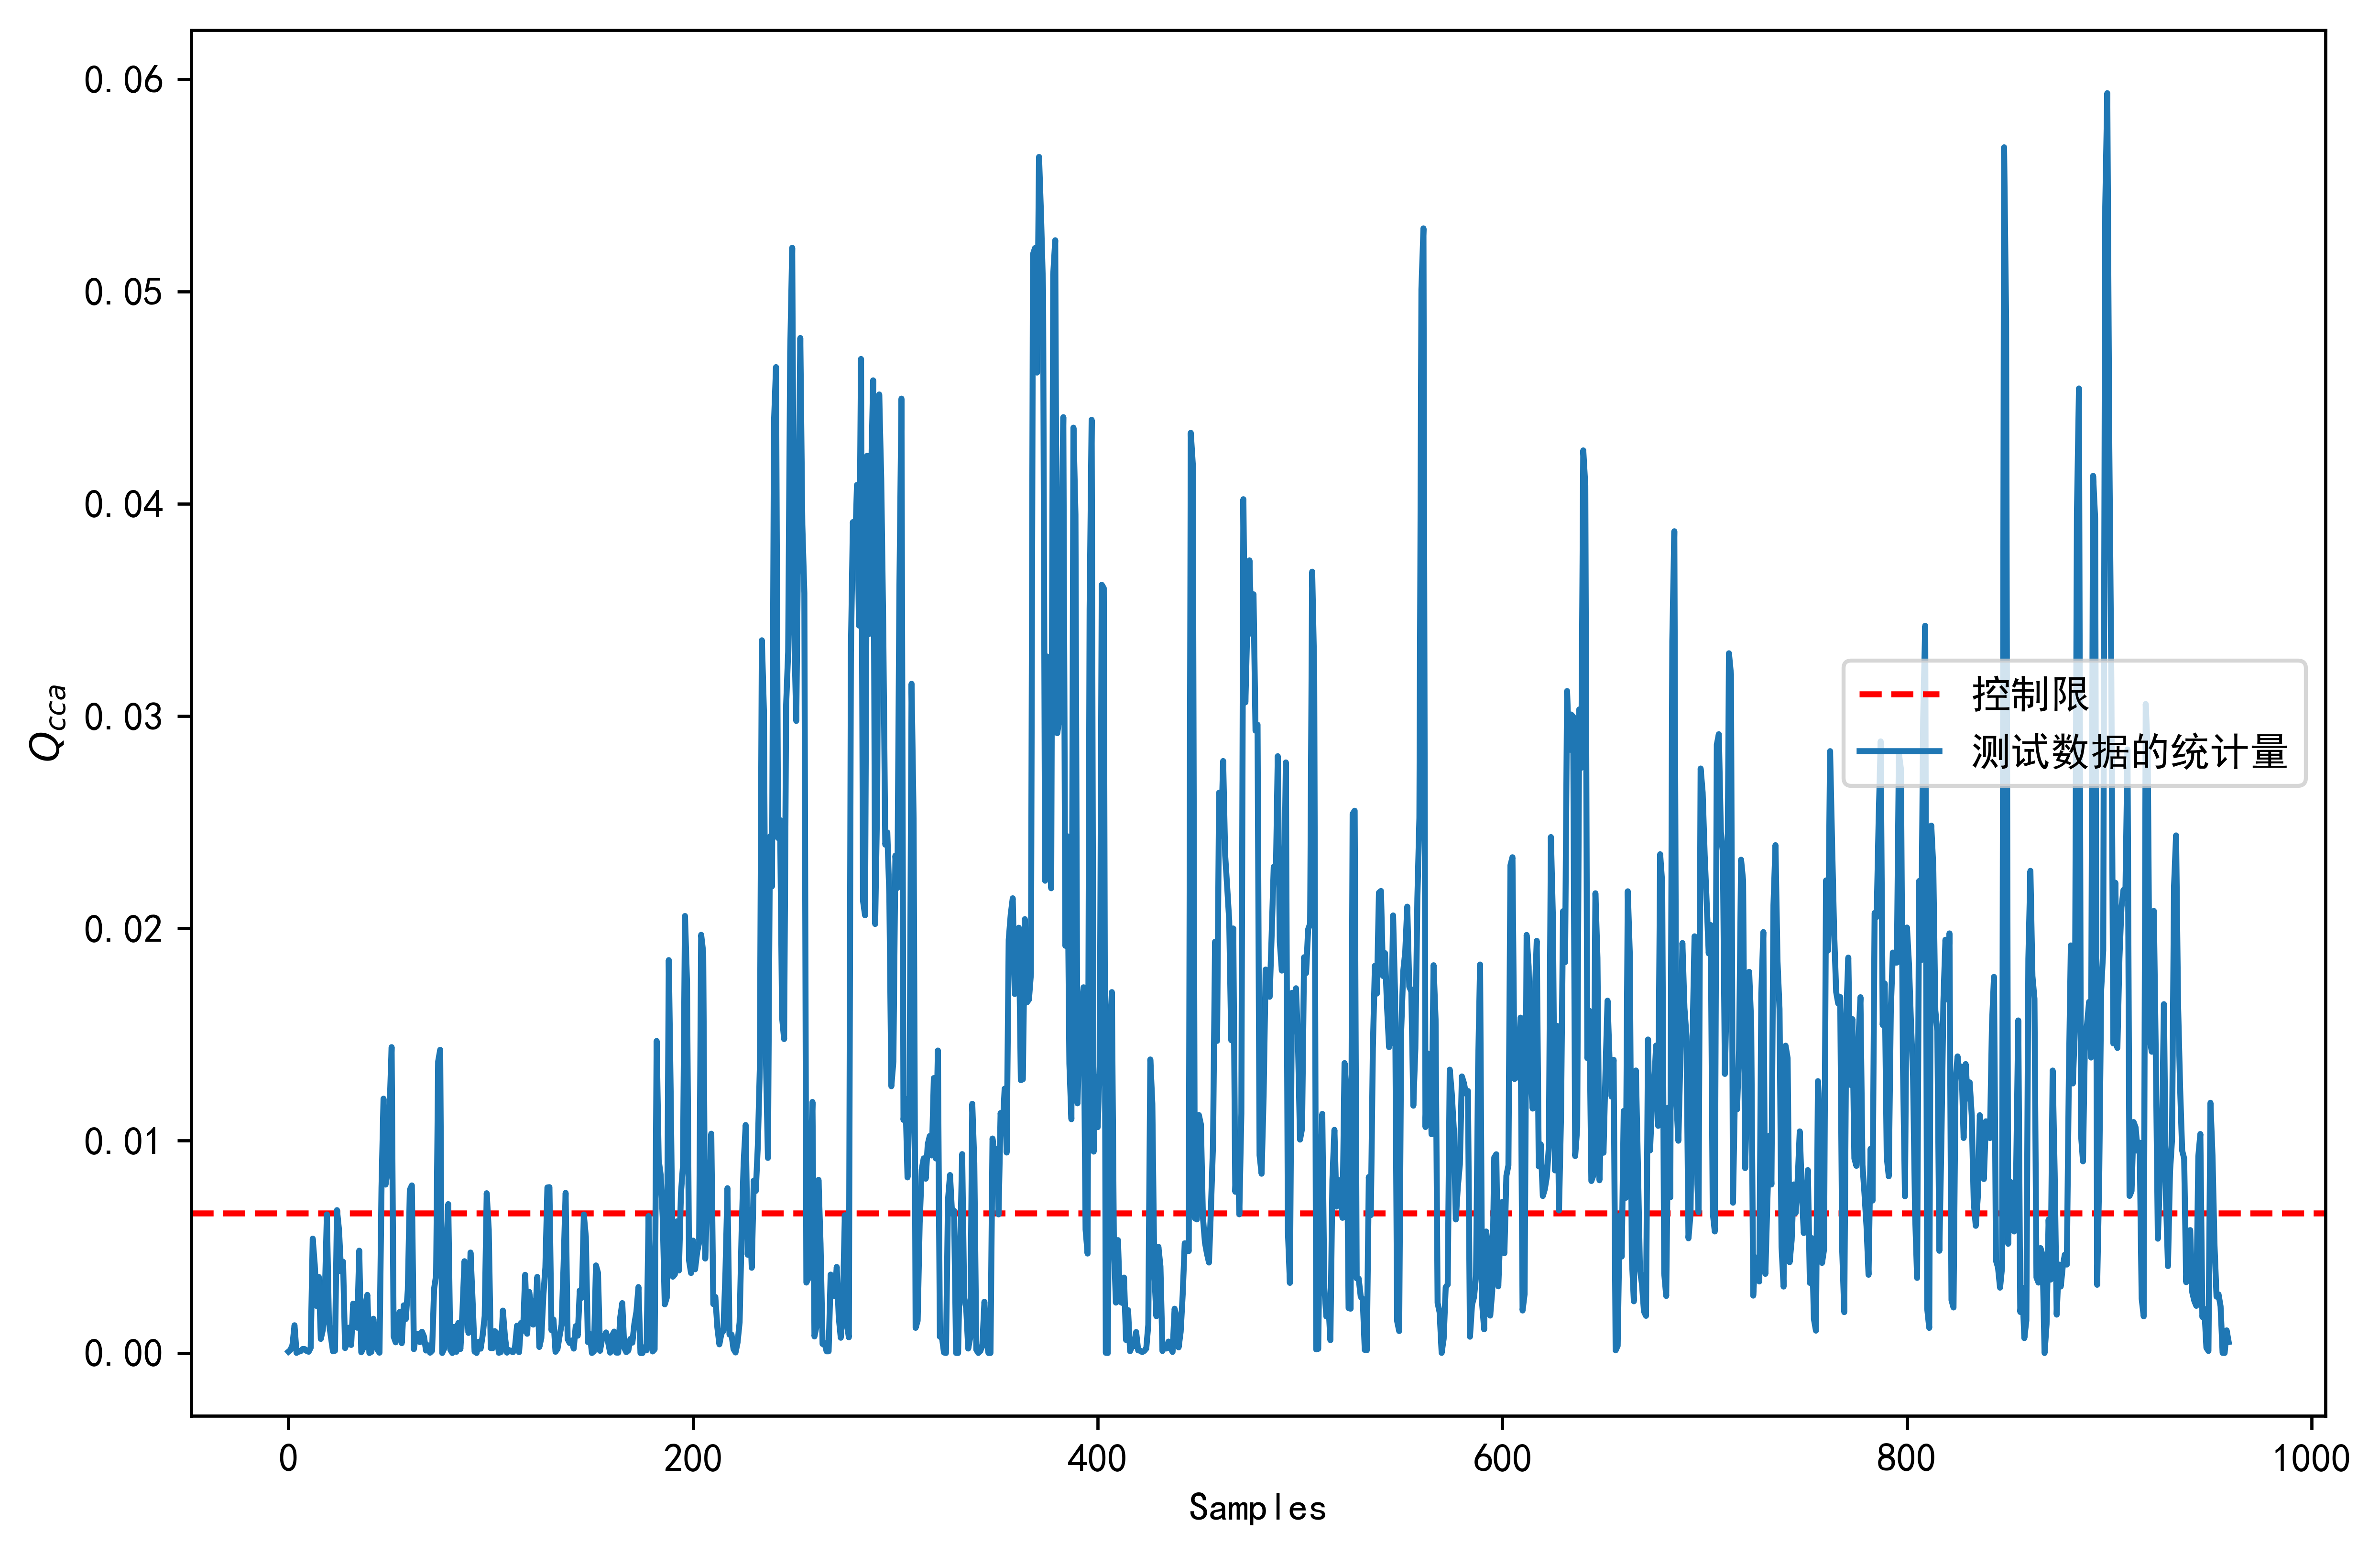

In [13]:
plt.figure(figsize=(9.6,6.4),dpi=600)
ax = plt.subplot(1,1,1)
ax.axhline(y=Q_cca_rd,ls="--",color="r",label='控制限')
ax.plot(Q_cca,label='测试数据的统计量')
ax.set_xlabel('Samples')
ax.set_ylabel('$Q_{cca}$')
ax.legend(loc="right")
plt.show()